In [174]:
import json
import numpy as np
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt

def interp(xp,fp):
    x=np.zeros(shape=(int(xp[-1]/20)+1,13), dtype=float)
    new_time=np.arange(0,xp[-1],20)
    for i in range(13):
        x[:,i]=np.interp(new_time,xp,fp[:,i])
    return new_time,x

class sensorData:
    def __init__(self,data,uuid,window=32,channel=9,frq=25):
        self.uuid=uuid
        self.frq  =frq
        self.window=window
        self.channel=channel
        
        self.gyro_x=[]
        self.gyro_y=[]
        self.gyro_z=[]
        self.gyro_time=[]
        self.lin_x=[]
        self.lin_y=[]
        self.lin_z=[]
        self.lin_time=[]
        self.grav_x=[]
        self.grav_y=[]
        self.grav_z=[]
        self.grav_time=[]
        self.valid=np.empty((0,9))
        self.validTime=[]
        self.fullData=np.empty((0,self.window,self.channel))
        self.fullData_norm=np.empty((0,self.window,self.channel*2))
        
        self.get_rawData(data)
        self.get_validData()
        self.get_fullData()
        self.data_len=self.fullData_norm.shape[0]
    def get_rawData(self,data):
        for i in range(len(data)):
            if data[i]["device_uuid"]==self.uuid:
                sdata=data[i]['sensor_data']
                for j in reversed(range(len(sdata))):
                    
                    sensor = sdata[j]['s']
                    if sensor==4 or sensor ==10 or sensor ==9:
                        x=sdata[j]['d']['x']
                        y=sdata[j]['d']['y']
                        z=sdata[j]['d']['z']
                        time=np.rint(sdata[j]['ts']/1000000)
                    if sensor==4:
                        self.gyro_x.append(x)
                        self.gyro_y.append(y)
                        self.gyro_z.append(z)
                        self.gyro_time.append(time)
                    if sensor==10:
                        self.lin_x.append(x)
                        self.lin_y.append(y)
                        self.lin_z.append(z)
                        self.lin_time.append(time)
                    if sensor==9:
                        self.grav_x.append(x)
                        self.grav_y.append(y)
                        self.grav_z.append(z)
                        self.grav_time.append(time)
       
        print(len(self.gyro_x),len(self.lin_x),len(self.grav_x))
        sortIndex = np.argsort(self.gyro_time)
        self.gyro_time=[self.gyro_time[i] for i in sortIndex]
        self.gyro_x=[self.gyro_x[i] for i in sortIndex]
        self.gyro_y=[self.gyro_y[i] for i in sortIndex]
        self.gyro_z=[self.gyro_z[i] for i in sortIndex]
        
        sortIndex = np.argsort(self.lin_time)
        self.lin_time = [self.lin_time[i] for i in sortIndex]
        self.lin_x = [self.lin_x[i] for i in sortIndex]
        self.lin_y = [self.lin_y[i] for i in sortIndex]
        self.lin_z = [self.lin_z[i] for i in sortIndex]
        
        sortIndex = np.argsort(self.grav_time)
        self.grav_time = [self.grav_time[i] for i in sortIndex]
        self.grav_x = [self.grav_x[i] for i in sortIndex]
        self.grav_y = [self.grav_y[i] for i in sortIndex]
        self.grav_z = [self.grav_z[i] for i in sortIndex]
        
        self.gyro_time,self.gyro_x,self.gyro_y,self.gyro_z=self.remove_duplicateData(self.gyro_time,self.gyro_x,self.gyro_y,self.gyro_z)
        self.lin_time,self.lin_x,self.lin_y,self.lin_z=self.remove_duplicateData(self.lin_time,self.lin_x,self.lin_y,self.lin_z)
        self.grav_time,self.grav_x,self.grav_y,self.grav_z=self.remove_duplicateData(self.grav_time,self.grav_x,self.grav_y,self.grav_z)
        
    def remove_duplicateData(self,time,x,y,z):
        index=[]
        for i in range(1,len(time)-1):
            if time[i]==time[i+1]:
                index.append(i+1)
        index.reverse()
        for i in range(len(index)):
            time.pop(index[i])
            x.pop(index[i])
            y.pop(index[i])
            z.pop(index[i])
        return time,x,y,z
        
    def get_validData(self):
        for i in range(len(self.lin_time)):
            time = self.lin_time[i]
            if (time in self.gyro_time) & (time in self.grav_time):
                gyroIndex=self.gyro_time.index(time)
                gravIndex=self.grav_time.index(time)
                data=[[self.gyro_x[gyroIndex],
                      self.gyro_y[gyroIndex],
                      self.gyro_z[gyroIndex],
                      self.lin_x[i],
                      self.lin_y[i],
                      self.lin_z[i],
                      self.grav_x[gravIndex],
                      self.grav_y[gravIndex],
                      self.grav_z[gravIndex]
                     ]]
                self.valid=np.append(self.valid,data,axis=0)
                self.validTime.append(time)
        
    def get_fullData(self):
        window=self.window
        channel=self.channel
        length=len(self.validTime)
        X=np.empty(shape=(length-window+1, window, channel))
        counter = 0
        unvalid_counter=0
        for i in range(0,length-window+1):
            if (self.validTime[i+window-1]-self.validTime[i]<window*1000/self.frq*1.1):
                X[counter,:,:channel] = self.valid[i:i+window,:]
                counter +=1
            else:
                #print(self.validTime[i+window-1]-self.validTime[i])
                unvalid_counter+=1
        #print(unvalid_counter)
        self.fullData=np.append(self.fullData,X[:counter,:,:],axis=0)
        self.fullData=self.scale(self.fullData)
        fullDataFFT = np.zeros(self.fullData.shape)
        for j in range(0,self.fullData.shape[0]):
            for k in range(0,self.channel):
                fft=np.fft.fft(self.fullData[j,:,k])
                fullDataFFT[j,:,k]=abs(fft)
        fullDataFFT=self.scale(fullDataFFT)
        print(fullDataFFT.shape)
        self.fullData_norm=np.append(self.fullData,fullDataFFT,axis=2)
    
    def scale(self,X):
        channel = (X.shape)[-1]
        for i in range(channel):
            mean = np.mean(X[:,:,i])
            std  = np.std(X[:,:,i])
            X[:,:,i]=np.tanh((X[:,:,i]-mean)/std)

        return X
    
    def save(self,url):
        url_raw = url+'_'+str(self.uuid)+'_raw.npy'
        np.save(url_raw,self.valid)
        url_raw_csv = url+'_'+str(self.uuid)+'_raw.csv'
        np.savetxt(url_raw_csv,self.valid,delimiter=",")
        url_norm = url+'_'+str(self.uuid)+'_norm.npy'
        np.save(url_norm,self.fullData_norm)


class sensorDatas:
    def __init__(self,data_url,window=32,channel=9):
        with open(data_url) as w:
            self.data = json.load(w)
        
        self.uuids=self.get_uuid(self.data)
        self.sensorDatas=[]
        self.data_len=0
        self.fullDatas=np.empty((0,window,channel*2))
        fileName = data_url.split('.json')[0]
        for i in range(len(self.uuids)):
            self.sensorDatas.append(sensorData(data=self.data,uuid=self.uuids[i]))
            self.fullDatas=np.append(self.fullDatas,self.sensorDatas[i].fullData_norm,axis=0)
            self.sensorDatas[i].save(fileName)
        
        np.save(fileName+'.npy',self.fullDatas)
            
        
    def get_uuid(self,data):
        uuid=[]
        for i in range(len(data)):
            if data[i]['device_uuid'] not in uuid:
                uuid.append(data[i]['device_uuid'])
        return uuid

In [150]:
data_url=r'C:\Users\Guo\Downloads\WatchData (28).json'

In [175]:
datas=sensorDatas(data_url)

27088 27100 27100
(4487, 32, 9)
30076 30062 30060
(14928, 32, 9)


bf7ff952e4163201


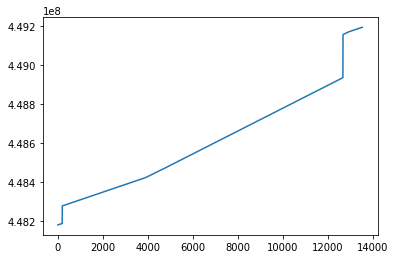

In [176]:
print(datas.sensorDatas[0].uuid)
plot(datas.sensorDatas[0].validTime)

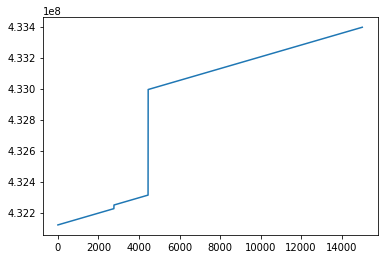

In [129]:
plot(datas.sensorDatas[1].validTime)